In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
import warnings
warnings.filterwarnings('ignore')
import string
import re
from unicodedata import normalize
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed,Bidirectional,GRU
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import corpus_bleu
import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from keras.layers import Dropout


def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [3]:
# How many sentences will be used
# Limit the sentences to 10.000 on Kaggle to avoid exceding the
# available RAM space
# Build a generator to avoid this issue

total_sentences = 85221

# Load the dataset
dataset = pd.read_excel("/content/drive/MyDrive/data.xlsx", nrows = total_sentences)


# What proportion of the sentences will be used for the test set
test_proportion = 0.3
train_test_threshold = int( (1-test_proportion) * total_sentences)

printmd(f'## {total_sentences} "parallel sentences" will be loaded (original sentence + its translation)')
printmd(f'## {train_test_threshold} "parallel sentences" will be used to train the model')
printmd(f'## {total_sentences-train_test_threshold} "parallel sentences" will be used to test the model')

## 85221 "parallel sentences" will be loaded (original sentence + its translation)

## 59654 "parallel sentences" will be used to train the model

## 25567 "parallel sentences" will be used to test the model

In [4]:
# Shuffle the dataset
dataset = dataset.sample(frac=1, random_state=0)
dataset.iloc[1000:1010]

,English,PSL
42870,The chief was deciding to be a good man.,Was The chief be a good man decides to now.
3261,I have an orange and an apple.,I an orange an apple have.
73922,I had hoped to meet her there.,was I there her meet hope full.
84184,I know that Shazim is agnostic.,I know that Shazim agnostic.
79760,He is a director and should be treated as such.,He director such treat.
61886,I can not believe Anees said yes.,I believe not was Anees say.
65728,Waasif did not follow the rules.,was Waasif rules follow not.
36340,It sounds very strange to me.,It me very strange sounds.
4064,Balam took off his belt.,was Balam his belt take off.
24879,We have just got to keep going.,We just go keep get full.


In [5]:
def clean(string):
    # Clean the string
    string = string.replace("\u202f"," ") # Replace no-break space with space
    string = string.lower()
    
    # Delete the punctuation and the numbers
    for p in punctuation + "«»" + "0123456789":
        string = string.replace(p," ")
        
        
    string = re.sub('\s+',' ', string)
    string = string.strip()
           
    return string

# Clean the sentences
dataset["English"] = dataset["English"].apply(lambda x: clean(x))
dataset["PSL"] = dataset["PSL"].apply(lambda x: clean(x))

# Select one part of the dataset
dataset = dataset.values
dataset = dataset[:total_sentences]

# split into train/test
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:]

# Define the name of the source and of the target
# This will be used in the outputs of this notebook
source_str, target_str = "English", "PSL"

# The index in the numpy array of the source and of the target
idx_src, idx_tar = 0,1

In [6]:
def create_tokenizer(lines):
    # fit a tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
def max_len(lines):
    # max sentence length
    return max(len(line.split()) for line in lines)

def encode_sequences(tokenizer, length, lines):
    # encode and pad sequences
    X = tokenizer.texts_to_sequences(lines) # integer encode sequences
    X = pad_sequences(X, maxlen=length, padding='post') # pad sequences with 0 values
    return X
 
def encode_output(sequences, vocab_size):
    # one hot encode target sequence
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
printmd(f'\nTarget ({target_str}) Vocabulary Size: {tar_vocab_size}')
printmd(f'Target ({target_str}) Max Length: {tar_length}')

# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
printmd(f'\nSource ({source_str}) Vocabulary Size: {src_vocab_size}')
printmd(f'Source ({source_str}) Max Length: {src_length}\n')
 



Target (PSL) Vocabulary Size: 8089

Target (PSL) Max Length: 14


Source (English) Vocabulary Size: 9256

Source (English) Max Length: 12


In [7]:
# Prepare training data (we can train data 10,000 because we are using free colab resource it is not able to train whole data.)

trainX = encode_sequences(src_tokenizer, src_length, train[56000:59654,idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[56000:59654,idx_tar])
trainY = encode_output(trainY, tar_vocab_size)

## Glove Embedding

In [8]:
# load embeding for text file
embeddings_index = dict()
f = open('/content/drive/MyDrive/Saved Models/glove.6B.300d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

In [9]:
dims=300
flag=1
word_index = {w: i for i, w in enumerate(embeddings_index, 1)}
embedding_matrix = np.zeros((len(word_index)+1, dims))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector[:dims]
        

In [10]:
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    # Create the model
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0],embedding_matrix.shape[1],weights=[embedding_matrix],input_length=src_timesteps,trainable=False))
    model.add(GRU(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(Dropout(0.1))
    model.add(GRU(n_units, return_sequences=True))

    model.add(TimeDistributed(Dense(tar_vocab, activation='sigmoid')))
    return model
 

In [11]:
# Create model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [12]:
history = model.fit(trainX, 
          trainY, 
          epochs=100, 
          batch_size=64, 
          validation_split=0.1, 
          verbose=1,
          callbacks=[
                        EarlyStopping(
                        monitor='val_loss',
                        patience=10,
                        restore_best_weights=True
                    )
            ])

In [13]:
model.save('/content/drive/MyDrive/reverse fyp/bilstm results/ENG_TO_PSL_gru_bs64_golvee_embedding.h5')

In [12]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/reverse fyp/bilstm results/ENG_TO_PSL_gru_bs64_golvee_embedding.h5')

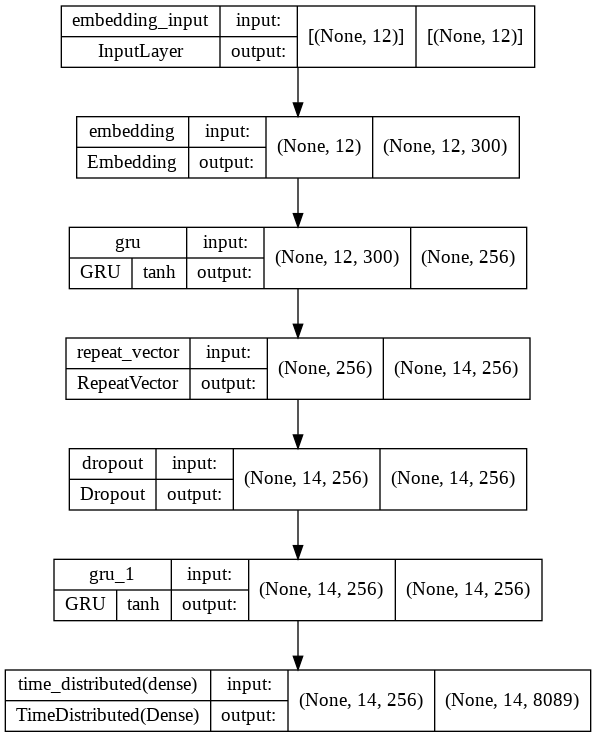

In [8]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_activations=True,show_layer_names=True)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 12, 300)           120000300 
                                                                 
 gru (GRU)                   (None, 256)               428544    
                                                                 
 repeat_vector (RepeatVector  (None, 14, 256)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 256)           0         
                                                                 
 gru_1 (GRU)                 (None, 14, 256)           394752    
                                                                 
 time_distributed (TimeDistr  (None, 14, 8089)         2078873   
 ibuted)                                                

### Testing Phase

#### First 10000

In [13]:
# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[20000:25567, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[20000:25567, idx_tar])
testY = encode_output(testY, tar_vocab_size)

In [19]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src,raw_target = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX,test[:10000,:])



### Result on the Test Set ###
ENGLISH (SOURCE)               PSL (TARGET)              AUTOMATIC TRANSLATION IN PSL

she had cooked food            was she food cook full    was she food cook full
i did not tell them            was i them tell not       was i them hurt not
i feel stupid                  i stupid feel             i stupid feel
ranjhoo will like it           ranjhoo it like after     ranjhoo it do after
they did not obey their parents was they their parents obey not was they their parents ask not
hello                          hello                     hello
i have eight brothers and sisters i brothers sisters have   i also bill watch have
i am going to go now           i now go go now           i now go go now
can i join in                  i join in yes no          i come yes yes
it was important               was it important          was it important
you have mail                  you mail full             you kid full
everybody knows i hate you     everybody know

### Bleu Score

In [20]:
def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src,raw_target = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

# Compute the BLEU Score
# bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX, test[:10000,:])

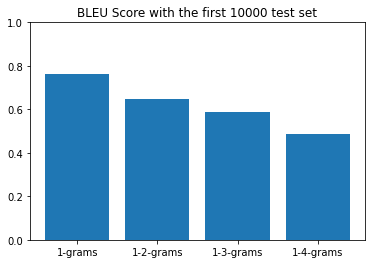

In [21]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with the first 10000 test set")
plt.ylim((0,1))
plt.show()

In [22]:
print(bleu_test)

{'1-grams': 0.7618517894108026, '1-2-grams': 0.6482386674164552, '1-3-grams': 0.5871550556280509, '1-4-grams': 0.48524625343031313}


## WER

In [24]:
!pip install jiwer
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    #print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src,raw_target = raw_dataset[i]
        #print(f'{raw_src:30} {raw_target:25} {translation}')
        #print(translation)     #predicit
        #print(raw_target)      #actual
        actual.append(raw_target)
        predicted.append(translation)
        if i >= limit: # Display some of the result
            return actual,predicted
            break
 
# # test on some training sequences!pip install jiwer
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
Actual,Predicted=compare_prediction(model, tar_tokenizer, testX,test[:10000,:])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Result on the Test Set ###


In [25]:
from jiwer import wer
error=wer(Actual,Predicted)
error

0.18181818181818182

### TER

In [26]:
!pip install pyter3
import pyter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
i=0
sum=0
while i<len(Actual):
  #print(pyter.ter(Actual[i].split(),Predicted[i].split()))
  sum+=pyter.ter(Actual[i].split(),Predicted[i].split())
  i=i+1



sum=sum/len(Actual)
sum

0.1912698412698413

#### 2nd 10000

In [16]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src,raw_target = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test[10000:20000,:])



### Result on the Test Set ###
ENGLISH (SOURCE)               PSL (TARGET)              AUTOMATIC TRANSLATION IN PSL

salman was quite frustrated    was salman quite frustrate was salman quite look
nihal showed me his new guitar was nihal his new guitar show was nihal his his me drive
sajeel comes here every other week sajeel other week here come sajeel here here here need
i changed direction            was i direction change    i i change
i am glad that ranjhoo won     i glad that was ranjhoo win i glad was ranjhoo glad
i will do whatever you want    i do after whatever you want i want want i i want
i know when hassam is lying    i know when hassam lie now i know when when lie now
he wishes to live his own way  he his own way live wish  was he his own own live live
manan and his wife live in karachi manan his wife karachi live inaam khan his wife gun
did he come home in the evening was he home come evening yes no was he home home evening yes no
i was able to do it today      was i t

In [17]:
def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src,raw_target = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

# Compute the BLEU Score
# bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX, test[10000:20000,:])

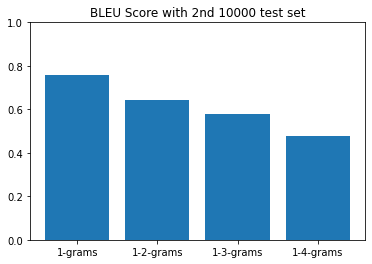

In [18]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with 2nd 10000 test set")
plt.ylim((0,1))
plt.show()

In [19]:
print(bleu_test)

{'1-grams': 0.7573932805687797, '1-2-grams': 0.6416203015492598, '1-3-grams': 0.5790275881643868, '1-4-grams': 0.47624235087922306}


### WER

In [27]:
!pip install jiwer
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    #print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src,raw_target = raw_dataset[i]
        #print(f'{raw_src:30} {raw_target:25} {translation}')
        #print(translation)     #predicit
        #print(raw_target)      #actual
        actual.append(raw_target)
        predicted.append(translation)
        if i >= limit: # Display some of the result
            return actual,predicted
            break
 
# # test on some training sequences!pip install jiwer
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
Actual,Predicted=compare_prediction(model, tar_tokenizer, testX, test[10000:20000,:])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Result on the Test Set ###


In [28]:
from jiwer import wer
error=wer(Actual,Predicted)
error

0.35344827586206895

### TER

In [29]:
!pip install pyter3
import pyter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
i=0
sum=0
while i<len(Actual):
  #print(pyter.ter(Actual[i].split(),Predicted[i].split()))
  sum+=pyter.ter(Actual[i].split(),Predicted[i].split())
  i=i+1



sum=sum/len(Actual)
sum

0.3673469387755103

### last 5567

In [14]:
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src,raw_target = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: # Display some of the result
            break
 
# test on some training sequences
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
compare_prediction(model, tar_tokenizer, testX, test[20000:25567,:])



### Result on the Test Set ###
ENGLISH (SOURCE)               PSL (TARGET)              AUTOMATIC TRANSLATION IN PSL

they are not helping old woman they old woman help now not they our woman help now not
we had the chances             was we chances had        was we mistake had
ashraf says i am too nosey     ashraf say i too nosey    ashraf say i too lucky
i haven t thought much about it i it much think full not  i much much think full not
i showed my room to zabhi      was i zabhi my room show  was i my room show show
the fight did not last long    was fight long last not   was long long long not
i think abbas wanted my help   i think was abbas my help want i think i i my help want
it was real scary              was it real scary         was it real concern
i like small towns             i small towns like        i enough uneasy like
i was not wearing a uniform    was i uniform wear now not was i bath wear now not
mahi is a good captain         mahi good captain         mahi good 

### Bleu Score

In [15]:
def bleu_score(model, tokenizer, sources, raw_dataset):
    # Get the bleu score of a model
    actual, predicted = [], []
    for i, source in enumerate(sources):
        # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src,raw_target = raw_dataset[i]
        actual.append([raw_target.split()])
        predicted.append(translation.split())
        
    bleu_dic = {}
    bleu_dic['1-grams'] = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu_dic['1-2-grams'] = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu_dic['1-3-grams'] = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu_dic['1-4-grams'] = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_dic

# Compute the BLEU Score
# bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_test = bleu_score(model, tar_tokenizer, testX,test[20000:25567,:])

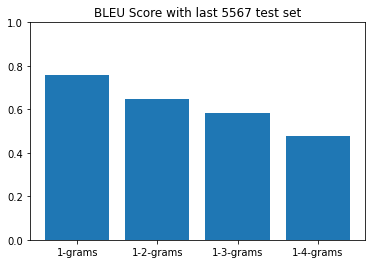

In [16]:
plt.bar(x = bleu_test.keys(), height = bleu_test.values())
plt.title("BLEU Score with last 5567 test set")
plt.ylim((0,1))
plt.show()

In [17]:
print(bleu_test)

{'1-grams': 0.759494786789765, '1-2-grams': 0.645264477548591, '1-3-grams': 0.5820684230634864, '1-4-grams': 0.47932525821515526}


### WER

In [18]:
!pip install jiwer
def word_for_id(integer, tokenizer):
    # map an integer to a word
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source):
    # generate target from a source sequence
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=20):
    # evaluate a model
    actual, predicted = [], []
    src = f'{source_str.upper()} (SOURCE)'
    tgt = f'{target_str.upper()} (TARGET)'
    pred = f'AUTOMATIC TRANSLATION IN {target_str.upper()}'
    #print(f'{src:30} {tgt:25} {pred}\n')
    
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_src,raw_target = raw_dataset[i]
        #print(f'{raw_src:30} {raw_target:25} {translation}')
        #print(translation)     #predicit
        #print(raw_target)      #actual
        actual.append(raw_target)
        predicted.append(translation)
        if i >= limit: # Display some of the result
            return actual,predicted
            break
 
# # test on some training sequences!pip install jiwer
# print('### Result on the Training Set ###')
# compare_prediction(model, tar_tokenizer, trainX, train)

# test on some test sequences
print('\n\n### Result on the Test Set ###')
Actual,Predicted=compare_prediction(model, tar_tokenizer, testX, test[20000:25567,:])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.8 MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149864 sha256=331d78723475d8c45fd7247485717b69e059ca6732b844d0eb3fe83503573fbc
  Stored in directory: /root/.cache/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein


### Result on the Test Set ###


In [19]:
from jiwer import wer
error=wer(Actual,Predicted)
error

0.22727272727272727

### TER

In [20]:
!pip install pyter3
import pyter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
i=0
sum=0
while i<len(Actual):
  #print(pyter.ter(Actual[i].split(),Predicted[i].split()))
  sum+=pyter.ter(Actual[i].split(),Predicted[i].split())
  i=i+1



sum=sum/len(Actual)
sum

0.23038548752834465

## Average score of all Testing

### AVERAGE BLEU SCORE

In [22]:
bleu_1=(0.76+0.75+0.75)/3
bleu_2=(0.64+0.64+0.64)/3
bleu_3=(0.58+0.57+0.58)/3
bleu_4=(0.48+0.47+0.47)/3




In [23]:
bleu_dic = {}
bleu_dic['1-grams']=bleu_1
bleu_dic['1-2-grams']= bleu_2
bleu_dic['1-3-grams']=bleu_3
bleu_dic['1-4-grams']=bleu_4


print(bleu_dic)

{'1-grams': 0.7533333333333333, '1-2-grams': 0.64, '1-3-grams': 0.5766666666666667, '1-4-grams': 0.47333333333333333}


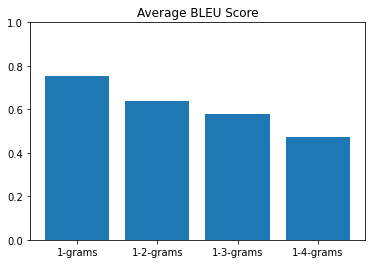

In [24]:
import matplotlib.pyplot as plt
plt.bar(x = bleu_dic.keys(), height = bleu_dic.values())
plt.title("Average BLEU Score")
plt.ylim((0,1))
plt.show()

In [1]:
wer=(0.18+0.35+0.22)/3
print(f"Average WER: {wer}")

ter=(0.19+0.36+0.23)/3
print(f'Average TER: {ter}')

Average WER: 0.25
Average TER: 0.26
